In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,
                            classification_report,confusion_matrix,roc_auc_score,roc_curve)



In [2]:
data= load_breast_cancer()
X = pd.DataFrame(data.data,columns=data.feature_names)
y = pd.Series(data.target,name="target")
print("Shape of X:", X.shape)
print("class Distribution (0=malignant,1=benign):/n",y.value_counts())
X.head()

Shape of X: (569, 30)
class Distribution (0=malignant,1=benign):/n target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.25,random_state=42,stratify=y
)
print("Train shape:",X_train.shape,"Test shape:",X_test.shape)

Train shape: (426, 30) Test shape: (143, 30)


In [4]:
rf= RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

In [5]:
acc=accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
rec=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision:{prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}\n")
print("Classification Report:\n", classification_report(y_test,y_pred,target_names=data.target_names))

Accuracy: 0.9580
Precision:0.9565
Recall: 0.9778
F1-Score: 0.9670

Classification Report:
               precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



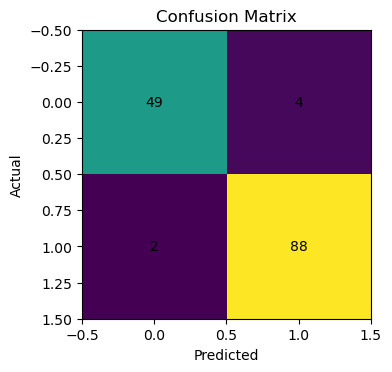

In [6]:
cm= confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm,interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.tight_layout()
plt.show()

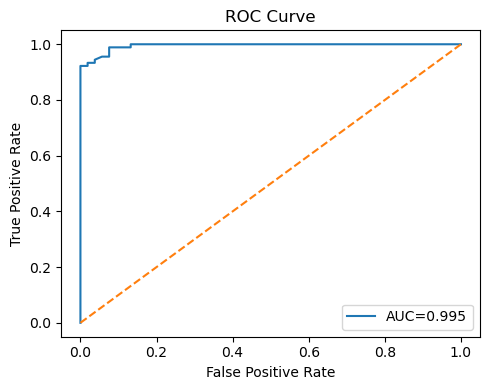

In [7]:
fpr,tpr,thresholds=roc_curve(y_test,y_proba)
auc=roc_auc_score(y_test,y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

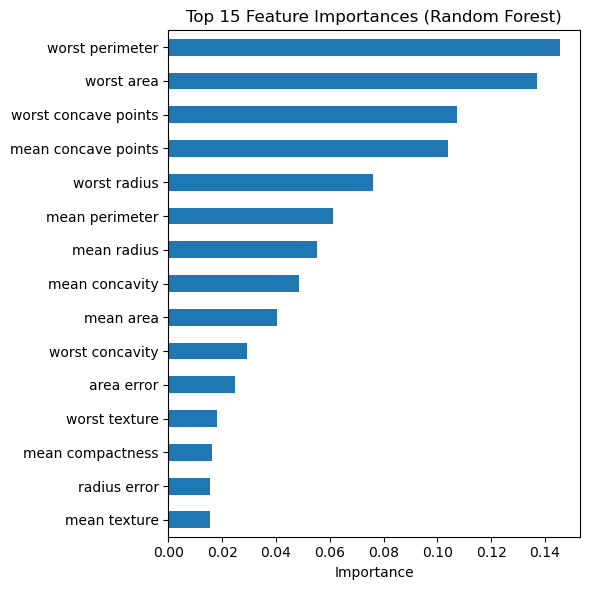

In [8]:
# 9) Feature Importance (top 15)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(6,6))
feat_imp.sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [9]:
# 10) Hyperparameter Tuning with GridSearchCV (quick grid)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',      # using F1 for balanced consideration
    cv=3,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("\nAfter Tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best))

Best Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

After Tuning:
Accuracy: 0.951048951048951
Precision: 0.9560439560439561
Recall: 0.9666666666666667
F1-score: 0.9613259668508287


In [10]:
# 11) Predict for a new patient (taking the first row as an example template)
new_patient = X_test.iloc[0:1].copy()
print("New sample (feature snapshot):\n", new_patient)

pred_class = best_rf.predict(new_patient)[0]
pred_prob = best_rf.predict_proba(new_patient)[0,1]

label_map = {0: "Malignant", 1: "Benign"}
print(f"\nPrediction: {label_map[pred_class]} (probability of benign = {pred_prob:.3f})")

New sample (feature snapshot):
      mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
519        12.75          16.7           82.51      493.8           0.1125   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
519            0.1117          0.0388              0.02995          0.212   

     mean fractal dimension  ...  worst radius  worst texture  \
519                 0.06623  ...         14.45          21.74   

     worst perimeter  worst area  worst smoothness  worst compactness  \
519            93.63       624.1            0.1475             0.1979   

     worst concavity  worst concave points  worst symmetry  \
519           0.1423               0.08045          0.3071   

     worst fractal dimension  
519                  0.08557  

[1 rows x 30 columns]

Prediction: Benign (probability of benign = 0.971)
